In [ ]:
# %% Load data and packages

from pyspark.sql import SparkSession, Row
from pyspark.sql import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, BooleanType
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession \
        .builder \
        .appName("Clustering") \
        .getOrCreate()

# Load Spotify data
df = spark.read.parquet('/home/mikezhu/music/data/spotify2020_preprocessed.parquet', header=True) 
print(df.count())
df.printSchema()

24/12/10 22:06:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
555910
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- duration: double (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
# %% vectorize features

# identify potentially relevant features and add to a feature dataframe
feature_cols = [
    #'explicit',
    #'liveness', 
    'energy',
    'loudness',
    'danceability',
    'valence',
    'tempo',
    'time_signature',
    'acousticness',
    'instrumentalness',
    'mode',
    'duration',
    'key',
    'speechiness'
]

# select feature columns and numeric data as floats
df_features = df.select(*(F.col(c) for c in feature_cols),'id') \
                         .dropna()

df_features = df_features.withColumn('features', F.array(*[F.col(c) for c in feature_cols])) \
                         .select('id', 'features')

# convert features to dense vector format (expected by K-Means, PCA)
vectors = df_features.rdd.map(lambda row: Vectors.dense(row.features))
features = spark.createDataFrame(vectors.map(Row), ["features_unscaled"])

# scale features (some values like duration_ms are much larger than others)
standardizer = StandardScaler(inputCol="features_unscaled", outputCol="features")
model = standardizer.fit(features)
features = model.transform(features) \
                .select('features')

# persist in memory before fit model
features.persist()

DataFrame[features: vector]

In [ ]:
# %% K-means and PCA functions

def find_optimal_pca_components(features,threshold=0.95,k=None):
    """
    Find optimal number of PCA components by analyzing explained variance
    
    Args:
        features: DataFrame with feature vectors
        feature_cols: List of feature column names
        
    Returns:
        optimal_n: Optimal number of components
        optimal_explained_variances: Array of explained variance ratios
        optimal_cumulative_variance: Array of cumulative explained variance ratios
        model: Trained PCA model
        pca_features: DataFrame with PCA-transformed feature vectors
    """
    n_features = features.first()["features"].size
    pca = PCA(k=n_features, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    explained_variances = model.explainedVariance
    cumulative_variance = [sum(explained_variances[:i+1]) for i in range(len(explained_variances))]

    # Print variance explained by each component
    for i, var in enumerate(explained_variances):
        print(f"Component {i+1} explained variance: {var:.4f}")
        print(f"Cumulative explained variance: {cumulative_variance[i]:.4f}")

    # Find optimal number of components
    if k is None:
        optimal_n = next((i for i, cum_var in enumerate(cumulative_variance) if cum_var >= threshold), len(cumulative_variance))
    else:
        optimal_n = k

    # Plot explained variance analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot scree plot
    ax1.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Scree Plot')
    ax1.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal number of components ({optimal_n})')

    # Plot cumulative variance
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    # Add threshold line at 0.8
    if k is None:
        ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    ax2.legend()
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.set_title('Cumulative Explained Variance Plot')

    plt.tight_layout()
    plt.show()

    if k is None:
        print(f"Optimal number of components: {optimal_n}, threshold: {threshold}")
    else:
        print(f"Optimal number of components: {optimal_n}")

    # transform features according to optimal number of components
    pca = PCA(k=optimal_n, inputCol="features", outputCol="pcaFeatures") 
    model = pca.fit(features)

    pca_features = model.transform(features) \
                        .select('pcaFeatures')
    
    optimal_explained_variances = explained_variances[:optimal_n]
    optimal_cumulative_variance = cumulative_variance[:optimal_n]

    return optimal_n, optimal_explained_variances, optimal_cumulative_variance, model, pca_features

def analyze_pca_composition(model_pca, feature_cols):
    """
    Analyze and visualize the composition of a trained PCA model using heatmap
    
    Args:
        model_pca: Trained PCA model
        feature_cols: List of original feature names
    """
    # Get principal components matrix
    pc_matrix = model_pca.pc.toArray()
    n_components = pc_matrix.shape[1]
    
    # Create DataFrame with component compositions
    components_df = pd.DataFrame(
        pc_matrix,
        columns=[f'PC{i}' for i in range(n_components)],
        index=feature_cols
    )
    
    # Plot heatmap
    plt.figure(figsize=(6, 8))
    im = plt.imshow(components_df, cmap='RdBu', aspect='auto')
    plt.colorbar(im, label='Component Weight')
    
    # Add value annotations
    for i in range(len(feature_cols)):
        for j in range(n_components):
            plt.text(j, i, f'{components_df.iloc[i, j]:.2f}',
                    ha='center', va='center')
    
    # Customize plot
    plt.xticks(range(n_components), components_df.columns)
    plt.yticks(range(len(feature_cols)), feature_cols)
    plt.title('PCA Components Composition')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    
    plt.tight_layout()
    plt.show()
    
    return components_df

def find_optimal_kmeans(features, k_values=range(3, 5),seed=1):
    """
    Find optimal k for KMeans clustering using silhouette scores
    
    Args:
        features: DataFrame with scaled feature vectors
        k_values: Range of k values to try
        
    Returns:
        optimal_k: Optimal number of clusters
        optimal_silhouette: Silhouette score for optimal k
        predictions: Predictions using optimal k
    """
    silhouettes = []
    feature_name = features.schema.names[0]
    print(feature_name)
    for k in k_values:
        # train model
        kmeans = KMeans(k=k, seed=seed, predictionCol='cluster', featuresCol=feature_name)
        model = kmeans.fit(features)
        
        # make predictions
        predictions = model.transform(features)
        
        # evaluate clustering
        evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol=feature_name)
        silhouette = evaluator.evaluate(predictions)
        silhouettes.append(silhouette)
        print(f"Silhouette score for k={k}: {silhouette}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouettes, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    
    # Add value labels on the points
    for k, silhouette in zip(k_values, silhouettes):
        plt.annotate(f'{silhouette:.3f}', 
                    (k, silhouette), 
                    textcoords="offset points", 
                    xytext=(0,10),
                    ha='center')
    
    plt.show()

    # find optimal k
    optimal_k = k_values[silhouettes.index(max(silhouettes))]
    print(f"\nOptimal number of clusters (k) = {optimal_k}")
    print(f"Best silhouette score = {max(silhouettes)}")
    
    # train final model with optimal k
    kmeans = KMeans(k=optimal_k, seed=seed, predictionCol='cluster', featuresCol=feature_name)
    kmeans_model = kmeans.fit(features)
    predictions = kmeans_model.transform(features)
    optimal_silhouette = evaluator.evaluate(predictions)
    
    return optimal_k, optimal_silhouette, predictions

def enhanced_pca_sample(df, viz_by_variable=None, sample_size=0.1, viz_N=5, seed=42):
    """
    Enhanced PCA visualization with distributed computation for large datasets
    
    Args:
        df: Spark DataFrame containing PCA features and metadata
        viz_by_variable: Variable name to color points by (optional)
        sample_size: Fraction of data to sample (default 0.1)
        viz_N: Number of categories/bins to visualize (default 5)
        seed: Random seed for sampling
    """
    # Remove rows where viz_by_variable is null before sampling
    df = df.filter(F.col(viz_by_variable).isNotNull())

    
    # Sample data using Spark
    sampled_data = df.sample(False, sample_size, seed=seed)
    
    feature_name = 'pcaFeatures'
    if viz_by_variable is None:
        viz_by_variable = 'cluster'

    # Get value type and statistics using Spark
    value_type = sampled_data.schema[viz_by_variable].dataType
    
    if viz_by_variable == 'release_date':
        # Sort and divide release_date into equal segments
        sorted_dates = sampled_data.select('release_date').distinct().orderBy('release_date').collect()
        num_dates = len(sorted_dates)
        segment_size = num_dates // viz_N
        date_segments = [sorted_dates[i * segment_size].release_date for i in range(viz_N)] + [sorted_dates[-1].release_date]

        # Create UDF for assigning date segments
        @F.udf(StringType())
        def assign_date_segment(date):
            for i in range(len(date_segments) - 1):
                if date_segments[i] <= date < date_segments[i + 1]:
                    return f'{date_segments[i]} - {date_segments[i + 1]}'
            return f'{date_segments[-2]} - {date_segments[-1]}'

        # Apply date segment mapping
        sampled_data = sampled_data.withColumn(
            'color_category',
            assign_date_segment(F.col('release_date'))
        )

        # Create color mapping
        colors = plt.cm.viridis(np.linspace(0, 1, viz_N))
        color_dict = dict(zip([f'{date_segments[i]} - {date_segments[i + 1]}' for i in range(viz_N)], colors))

        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                      markerfacecolor=color_dict[seg],
                                      label=seg, markersize=10)
                           for seg in color_dict.keys()]
    
    elif isinstance(value_type, (StringType, BooleanType)):  # Categorical variable
        # Get value counts using Spark
        value_counts = (sampled_data
                       .groupBy(viz_by_variable)
                       .count()
                       .orderBy('count', ascending=False)
                       .limit(viz_N-1))
        
        top_categories = [row[viz_by_variable] for row in value_counts.collect()]
        
        # Create color mapping
        colors = plt.cm.Dark2(np.linspace(0, 1, len(top_categories) + 1))
        color_dict = dict(zip(top_categories, colors[:-1]))
        color_dict['Others'] = colors[-1]
        
        # Create UDF for category mapping
        @F.udf(StringType())
        def map_categories(x):
            return x if x in top_categories else 'Others'
        
        # Apply category mapping in Spark
        sampled_data = sampled_data.withColumn(
            'color_category', 
            map_categories(F.col(viz_by_variable))
        )
        
        # Create legend handles
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=color_dict[cat], 
                                    label=cat, markersize=10)
                         for cat in list(top_categories) + ['Others']]
        
    else:  # Continuous variable
        # Calculate min and max using Spark
        stats = sampled_data.agg(
            F.min(viz_by_variable).alias('min'),
            F.max(viz_by_variable).alias('max')
        ).collect()[0]
        
        # Create bins
        bins = np.linspace(stats['min'], stats['max'], viz_N+1)
        labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
        
        # Create UDF for binning
        @F.udf(StringType())
        def assign_bin(value):
            if value is None:
                return None
            for i in range(len(bins)-1):
                if bins[i] <= value < bins[i+1]:
                    return labels[i]
            return labels[-1]
        
        # Apply binning in Spark
        sampled_data = sampled_data.withColumn(
            'color_category',
            assign_bin(F.col(viz_by_variable))
        )
        
        # Create color mapping
        colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
        color_dict = dict(zip(labels, colors))
        
        # Create colorbar handles
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                  norm=plt.Normalize(vmin=stats['min'], 
                                                   vmax=stats['max']))
    
    # Convert to pandas only for final plotting
    # Extract only necessary columns
    plot_data = sampled_data.select(
        feature_name,
        'color_category'
    ).toPandas()
    
    # Extract coordinates for plotting
    coords = np.vstack(plot_data[feature_name].values)
    point_colors = [color_dict[cat] for cat in plot_data['color_category']]
    
    # Define dimension combinations for plotting
    dim_combinations = [(0,1), (0,2), (1,2)]
    
    # Set up the plotting grid
    fig = plt.figure(figsize=(15, 5))
    
    # Plot each dimension combination
    for idx, (dim1, dim2) in enumerate(dim_combinations):
        ax = fig.add_subplot(1, 3, idx+1)
        
        if viz_by_variable:
            scatter = ax.scatter(coords[:, dim1], coords[:, dim2], 
                               c=point_colors, alpha=0.6)
            
            # Add legend/colorbar
            if isinstance(value_type, (StringType, BooleanType)) or viz_by_variable == 'release_date':
                ax.legend(handles=legend_elements, title=viz_by_variable,
                         bbox_to_anchor=(1.05, 1), loc='upper left')
            else:  # Continuous variable
                sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                                         norm=plt.Normalize(vmin=stats['min'], 
                                                         vmax=stats['max']))
                plt.colorbar(sm, ax=ax, label=viz_by_variable)
        else:
            ax.scatter(coords[:, dim1], coords[:, dim2], alpha=0.6)
        
        ax.set_xlabel(f'PC{dim1+1}')
        ax.set_ylabel(f'PC{dim2+1}')
        ax.grid(True, alpha=0.3)
        
        # Set consistent axis limits
        ax.set_xlim(coords[:, dim1].min() - 0.5, coords[:, dim1].max() + 0.5)
        ax.set_ylim(coords[:, dim2].min() - 0.5, coords[:, dim2].max() + 0.5)
    
    plt.suptitle('PCA Distribution in Different Dimension Combinations', y=1.05)
    plt.tight_layout()
    plt.show()


def show_top_songs_by_cluster(df_kmeans, optimal_k_pca, n_songs=10):
    """
    Show top N songs by popularity for each cluster.
    
    Args:
        df_kmeans: DataFrame with cluster assignments and song metadata
        optimal_k_pca: Number of clusters
        n_songs: Number of top songs to show per cluster (default 10)
    """
    # Show distribution of clusters
    df_kmeans.groupBy('cluster').count().orderBy('cluster').show()

    # Create window spec for ranking within clusters
    window_spec = Window.partitionBy('cluster').orderBy(F.col('popularity').desc())

    # Get top N songs for each cluster
    df_kmeans_top = df_kmeans.withColumn('rank', F.row_number().over(window_spec)) \
                     .filter(F.col('rank') <= n_songs) \
                     .select('cluster', 'name', 'artists', 'popularity', 'release_date', 'rank')

    # Show results for each cluster
    for i in range(optimal_k_pca):
        print(f"\nCluster {i}:")
        df_kmeans_top.filter(F.col('cluster') == i) \
                 .orderBy('rank') \
                 .show(truncate=False)

24/12/10 22:07:00 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/10 22:07:00 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Component 1 explained variance: 0.2522
Cumulative explained variance: 0.2522
Component 2 explained variance: 0.1135
Cumulative explained variance: 0.3657
Component 3 explained variance: 0.0952
Cumulative explained variance: 0.4609
Component 4 explained variance: 0.0865
Cumulative explained variance: 0.5474
Component 5 explained variance: 0.0794
Cumulative explained variance: 0.6268
Component 6 explained variance: 0.0781
Cumulative explained variance: 0.7049
Component 7 explained variance: 0.0724
Cumulative explained variance: 0.7772
Component 8 explained variance: 0.0697
Cumulative explained variance: 0.8469
Component 9 explained variance: 0.0669
Cumulative explained variance: 0.9138
Component 10 explained variance: 0.0409
Cumulative explained variance: 0.9547
Component 

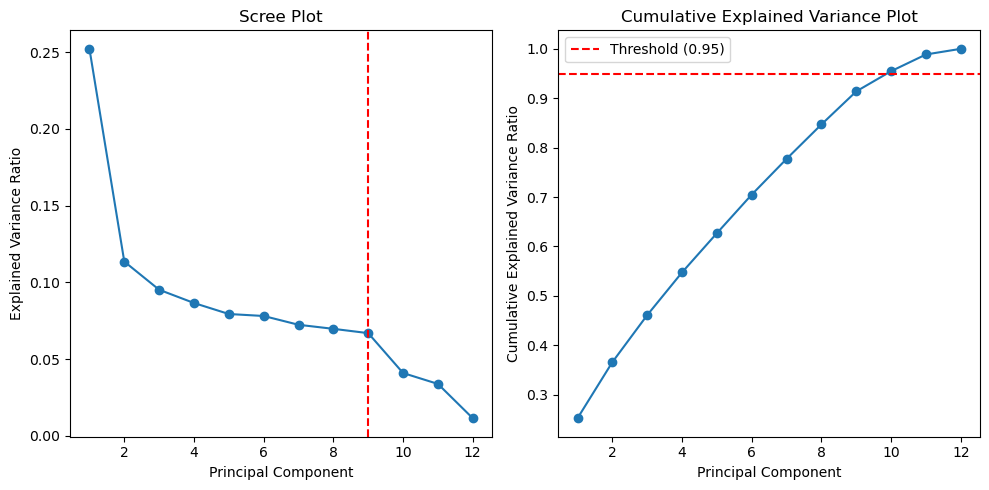

Optimal number of components: 9, threshold: 0.95


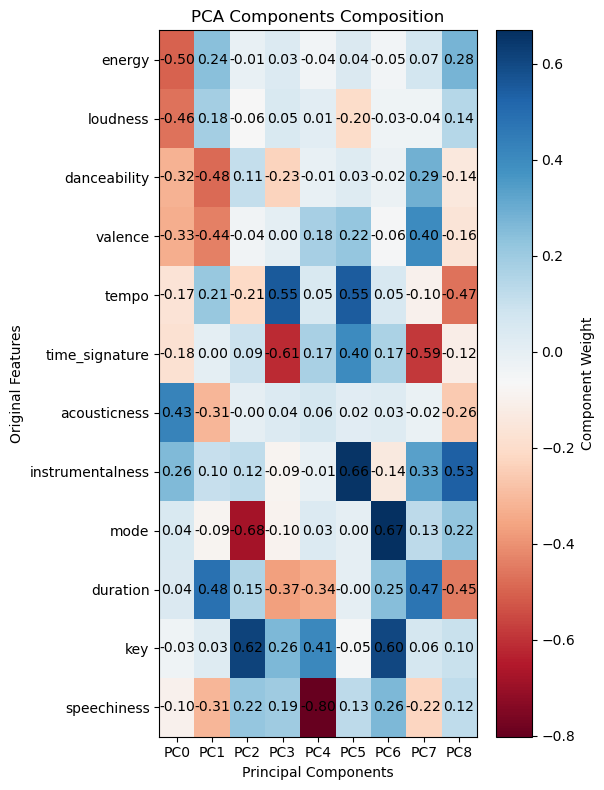

In [ ]:
# %% 1. PCA: find optimal number of components

optimal_n, optimal_explained_variances, optimal_cumulative_variance, model_pca, features_pca = find_optimal_pca_components(features)
components_df = analyze_pca_composition(model_pca, feature_cols)

pcaFeatures


Silhouette score for k=2: 0.3446590813836899


Silhouette score for k=3: 0.1894861779655644


Silhouette score for k=4: 0.2359331631449847
Silhouette score for k=5: 0.22151653496259013
Silhouette score for k=6: 0.21836804481566402
Silhouette score for k=7: 0.22416367003299179
Silhouette score for k=8: 0.2289763425132046
Silhouette score for k=9: 0.2277277643070148
Silhouette score for k=10: 0.21995723718493204
Silhouette score for k=11: 0.19842248792505454
Silhouette score for k=12: 0.2267218829113163


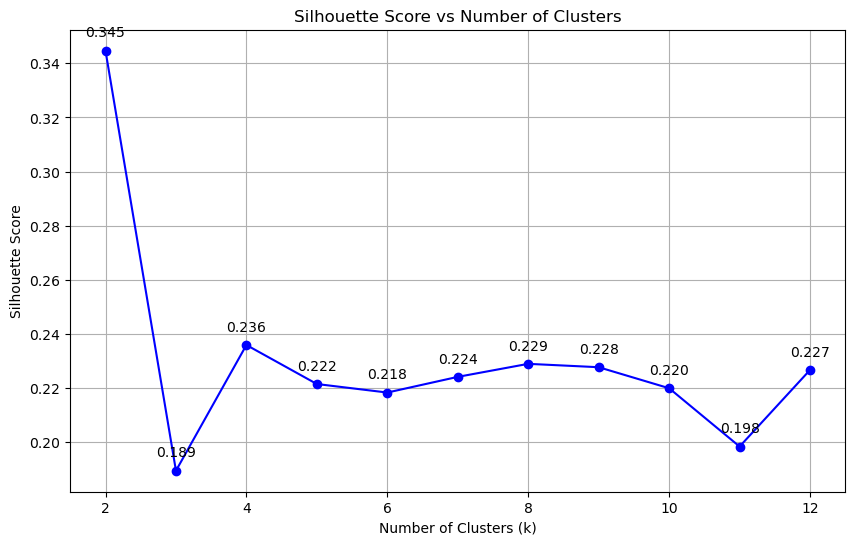


Optimal number of clusters (k) = 2
Best silhouette score = 0.3446590813836899


In [ ]:
# %% 2. KMeans: find optimal k, based on PCA-transformed features

features_pca.persist()
optimal_k_pca, optimal_silhouette_pca, predictions_kmeans = find_optimal_kmeans(features_pca,k_values=range(2, 13))

+--------------------+--------------------+-------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------------+----+
|                  id|         pcaFeatures|cluster|            features|                name|popularity|explicit|             artists|          id_artists|release_date|danceability|energy| key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|          duration|year|
+--------------------+--------------------+-------+--------------------+--------------------+----------+--------+--------------------+--------------------+------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------------+----+
|000mGrJNc2GAgQdME...|[0.67340790683567...|      0|[0.1500

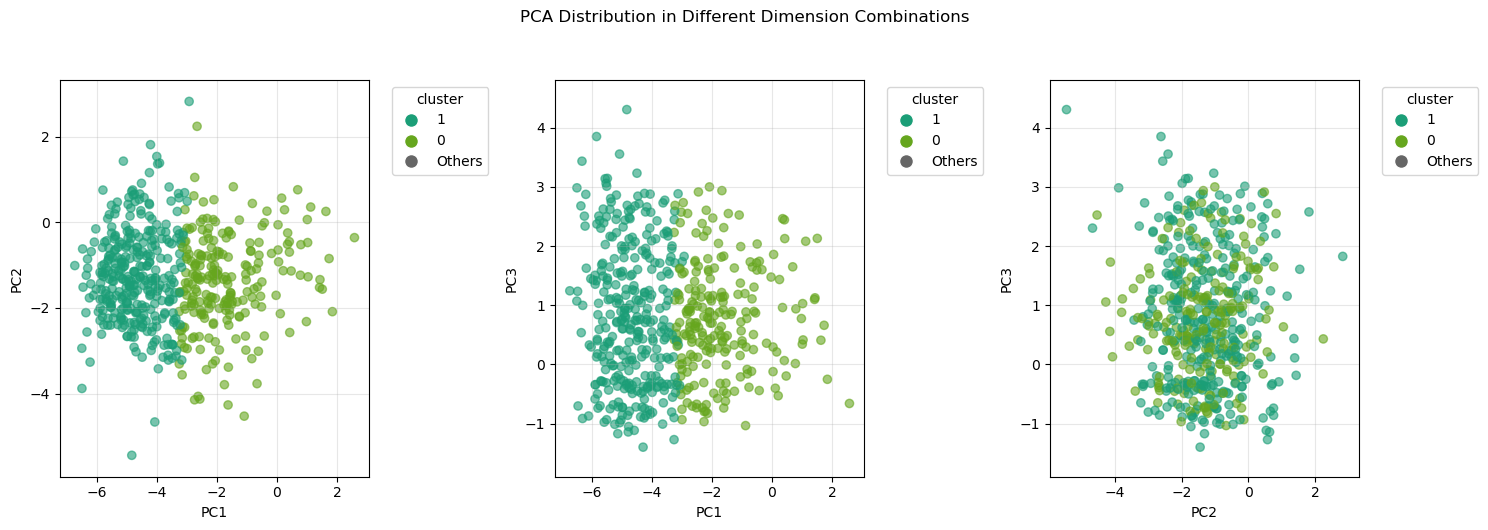

+-------+------+
|cluster| count|
+-------+------+
|      0|198134|
|      1|357776|
+-------+------+


Cluster 0:


+-------+----------------------+---------------------------+----------+------------+----+
|cluster|name                  |artists                    |popularity|release_date|rank|
+-------+----------------------+---------------------------+----------+------------+----+
|0      |Heartbreak Anniversary|['Giveon']                 |94.0      |2020-03-27  |1   |
|0      |you broke me first    |['Tate McRae']             |91.0      |2020-04-17  |2   |
|0      |Someone You Loved     |['Lewis Capaldi']          |90.0      |2019-05-17  |3   |
|0      |lovely (with Khalid)  |['Billie Eilish', 'Khalid']|89.0      |2018-04-19  |4   |
|0      |Arcade                |['Duncan Laurence']        |89.0      |2019-03-07  |5   |
|0      |Heather               |['Conan Gray']             |89.0      |2020-03-20  |6   |
|0      |Afterglow             |['Ed Sheeran']             |88.0      |2020-12-21  |7   |
|0      |All of Me             |['John Legend']            |87.0      |2013-08-30  |8   |
|0      |e

In [ ]:
# %% 3. merge cluster results

# merge df_features and predictions_kmeans horizontally, then merge with df by `id`, inner method
df_kmeans = predictions_kmeans.withColumn("tmp_id", F.monotonically_increasing_id()) \
            .join(df_features.withColumn("tmp_id", F.monotonically_increasing_id()), "tmp_id") \
            .drop("tmp_id") \
            .join(df,on=["id"],how="inner") \
            .withColumn("cluster", F.col("cluster").cast(StringType()))

df_kmeans.show()
df_kmeans.count()
df_kmeans.printSchema()

enhanced_pca_sample(df_kmeans,viz_by_variable='cluster',sample_size=0.001)
show_top_songs_by_cluster(df_kmeans, optimal_k_pca, n_songs=10)

In [ ]:
df_kmeans.write.mode('overwrite').parquet('/home/mikezhu/music/data/spotify2020_pca.parquet')
